Grid searching is generally not an operation that we can perform with deep learning methods. This is because deep learning methods often require large amounts of data and large models, together resulting in models that take hours, days, or weeks to train. In those cases __where the datasets are smaller__, such as __univariate time series__, it may be possible to use a grid search to tune the hyperparameters of a deep learning model.

- How to develop a generic grid searching framework for tuning model hyperparameters.
- How to grid search hyperparameters for a Multilayer Perceptron model on the airline passengers univariate time series forecasting problem.
- How to adapt the framework to grid search hyperparameters for convolutional and long short-term memory neural networks.

## 15.1 Tutorial Overview
This tutorial is divided into five parts; they are:
1. Time Series Problem
2. Grid Search Framework
3. Multilayer Perceptron Model
4. Convolutional Neural Network Model
5. Long Short-Term Memory Network Model

## 15.2 Time Series Problem
1. We will use the monthly airline passenger dataset as this context as it includes the complexity of both trend and seasonal elements. The monthly airline passenger dataset summarizes the monthly total number of international passengers in thousands on for an airline from 1949 to 1960. 
2. The dataset is monthly and has 12 years, or 144 observations. In our testing, we will use the last year, or 12 observations, as the test set.

(144, 1)


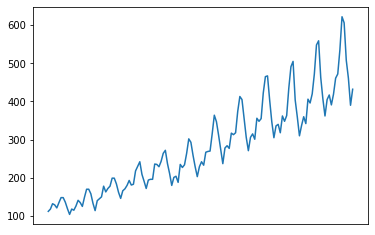

In [1]:
# load and plot monthly airline passengers dataset
from pandas import read_csv
from matplotlib import pyplot
%matplotlib inline 
# load
series = read_csv('monthly-airline-passengers.csv', header=0, index_col=0)
# summarize shape
print(series.shape)
# plot
pyplot.plot(series)
pyplot.xticks([])
pyplot.show()

 From prior experiments, a naive model can achieve a root mean squared error, or RMSE, of 50.70 (remember the units are thousands of passengers) by persisting the value from 12 months ago (relative index -12). It should be noted that a tuned ETS model can achieve an RMSE of 17.09 and a tuned SARIMA can achieve an RMSE of 13.89. These provide a lower bound on the expectations of a well-tuned deep learning model for this problem. 

## 15.3 Develop a Grid Search Framework


In this section, we will develop a grid search test harness that can be used to evaluate a range of hyperparameters for different neural network models, such as MLPs, CNNs, and LSTMs. This section is divided into the following parts:
1. Train-Test Split
2. Series as Supervised Learning 3. Walk-Forward Validation
4. Repeat Evaluation
5. Summarize Performance
6. Worked Example

### 15.3.1 Train-Test Split

We will use the first 11 years (132 observations) for training and the last 12 for the test set.

### 15.3.2 Series as Supervised Learning
1. A supervised learning framing of a series means that the data needs to be split into multiple examples that the model learns from and generalizes across. Each sample must have both an input component and an output component. The input component will be some number of prior observations, such as three years, or 36 time steps.
2. The output component will be the total sales in the next month because we are interested in developing a model to make one-step forecasts. We can implement this using the shift() function on the Pandas DataFrame. It allows us to shift a column down (forward in time) or back (backward in time). <br>
(t) <br>
1   <br>
2   <br>
3   <br>
4   <br>
This column can be shifted and inserted as a column beforehand: <br>
(t-1), 　　(t) <br>
Nan,　　1  <br>
1,　　　2 <br>
2,　　　3 <br>
3,　　　4 <br>
4,　　　NaN <br>

### 15.3.3 Walk-Forward Validation

1. Time series forecasting models can be evaluated on a test set using walk-forward validation. Walk-forward validation is an approach where the model makes a forecast for each observation in the test dataset one at a time. After each forecast is made for a time step in the test dataset, the true observation for the forecast is added to the test dataset and made available to the model. 
2. Simpler models can be refit with the observation prior to making the subsequent prediction. More complex models, such as neural networks, are not refit given the much greater computational cost.
3. RMSE is calculated as the square root of the average of the squared differences between the forecasts and the actual values

### 15.3.4 Repeat Evaluation

1. Neural network models are stochastic. This means that, given the same model configuration and the same training dataset, __a different internal set of weights will result each time the model is trained that will, in turn, have a different performance__. This is a benefit, allowing the model to be adaptive and find high performing configurations to complex problems. It is also a problem when evaluating the performance of a model and in choosing a final model to use to make predictions.
2. To address model evaluation, we will evaluate a model configuration multiple times via walk-forward validation and report the error as the average error across each evaluation.

### 15.3.5 Grid Search
All that is left is a function to drive the search. We can define a grid search() function that takes the dataset, a list of configurations to search, and the number of observations to use as the test set and perform the search. 

### 15.3.6 Worked Example

In [2]:
# grid search persistence models for monthly airline passengers data 
from math import sqrt 
from numpy import mean 
from pandas import read_csv 
from sklearn.metrics import mean_squared_error 

# split a univariate dataset into train/test sets 
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

def model_fit(train, config):
	return None

# forecast with a pre-fit model
def model_predict(model, history, offset):
	return history[-offset]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = []
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# convert config to a key
	key = str(config)
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	# summarize score
	result = mean(scores)
	print('> Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs 
def grid_search(data, cfg_list, n_test):
    # evaluate configs 
    scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores 

# define dataset
series = read_csv('monthly-airline-passengers.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# model configs
cfg_list = [1, 6, 12, 24, 36]
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 10 configs
for cfg, error in scores[:10]:
	print(cfg, error)

 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
> Model[1] 53.152
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
> Model[6] 126.735
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
> Model[12] 50.708
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
> Model[24] 97.110
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
> Model[36] 110.274
done
12 50.708316214732804
1 53.1515129919491
24 97.10990337413241
36 110.27352356753639
6 126.73495965991387


We can see, as we might have expected, that persisting the value from one year ago (relative offset -12) resulted in the best performance for the persistence model.

## 15.4 Multilayer Perceptron Model

1. we will grid search hyperparameters for an MLPs for univariate time series forecasting. We will define a very simple model with one hidden layer and define five hyperparameters to tune. They are:
   - n_input: The number of prior inputs to use as input for the model (e.g. 12 months). 
   - n_nodes: The number of nodes to use in the hidden layer (e.g. 50).
   - n_epochs: The number of training epochs (e.g. 1000).
   - n_batch: The number of samples to include in each mini-batch (e.g. 32).
   - n_diff: The difference order (e.g. 0 or 12).

2. Recall that __differencing__ is the transform of the data such that a value of a prior observation is subtracted from the current observation, removing trend or seasonality structure. We will add support for differencing to the grid search test harness, just in case it adds value to your specific problem.

3. If the data was differenced, the difference must be inverted for the prediction of the model. This involves adding the value at the relative offset from the history back to the value predicted by the model.

In [9]:
# grid search mlps for monthly airline passengers dataset
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format 
def series_to_supervised(data, n_in, n_out=1):
    # param: data, previous steps, output size
    # return: shifted data with target in list
    df = DataFrame(data)
    cols = []
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        
    # put it all together
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = concat(cols, axis=1)
    # drop rows with NaN values 
    agg.dropna(inplace=True)
    return agg.values 

# root mean squared error
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, order):
    return [data[i] - data[i - order] for i in range(order, len(data))]

# fit a model 
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data 
    if n_diff > 0:
        train = difference(train, n_diff)
    # transform series into supervised format 
    data = series_to_supervised(train, n_in=n_input)
    # separate inputs and outputs 
    train_x, train_y = data[:, :-1], data[:, -1]
    # define model 
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit model 
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model 

# forecast with the fit model 
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, n_diff = config 
    # prepare data 
    correction = 0.0 
    # do the differencing for test data
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    # shape input for model 
    x_input = array(history[-n_input:]).reshape((1, n_input))
    # make forecast 
    yhat = model.predict(x_input, verbose=0)
    # correct forecast if it was differenced
    return correction + yhat[0]

# walk-forward validation for univariate data 
def walk_forward_validation(data, n_test, cfg):
    predictions = []
    # split dataset 
    train, test = train_test_split(data, n_test)
    # fit model 
    model = model_fit(train, cfg)
    # seed history with training dataset 
    history = [x for x in train]
    # step over each time-step in the test set 
    for i in range(len(test)):
        # fit model and make forecast for history 
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions 
        predictions.append(yhat)
        # add actual observation to history for the next loop 
        history.append(test[i])
    # estimate prediction error 
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error 

# score a model, return None on failure 
def repeat_evaluate(data, config, n_test, n_repeats=10):
    # convert config to a key 
    key = str(config)
    # fit and evaluate the model n times 
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    # summarize score 
    result = mean(scores)
    print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

# grid search configs 
def grid_search(data, cfg_list, n_test):
    # evaluate configs 
    scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
    # sort configs by error, asc 
    scores.sort(key=lambda tup: tup[1])
    return scores 

# create a list of configs to try 
def model_configs():
	# define scope of configs
	n_input = [12]
	n_nodes = [50, 100]
	n_epochs = [100]
	n_batch = [1, 150]
	n_diff = [0, 12]
	# create configs
	configs = []
	for i in n_input:
		for j in n_nodes:
			for k in n_epochs:
				for l in n_batch:
					for m in n_diff:
						cfg = [i, j, k, l, m]
						configs.append(cfg)
	print('Total configs: %d' % len(configs))
	return configs

# define dataset
series = read_csv('monthly-airline-passengers.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# model configs
cfg_list = model_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
	print(cfg, error)

Total configs: 8
 > 19.147
 > 17.075
 > 20.223
 > 19.124
 > 31.867
 > 18.374
 > 18.077
 > 24.383
 > 18.735
 > 42.946
 > Model[[12, 50, 100, 1, 0]] 22.995
 > 20.709
 > 18.532
 > 22.557
 > 18.905
 > 20.716
 > 20.847
 > 18.765
 > 21.490
 > 18.564
 > 18.390
 > Model[[12, 50, 100, 1, 12]] 19.948
 > 13.966
 > 70.475
 > 73.612
 > 70.590
 > 73.141
 > 63.098
 > 65.062
 > 49.381
 > 52.060
 > 57.599
 > Model[[12, 50, 100, 150, 0]] 58.898
 > 18.863
 > 18.606
 > 18.656
 > 18.722
 > 21.560
 > 19.503
 > 18.973
 > 19.832
 > 18.090
 > 19.991
 > Model[[12, 50, 100, 150, 12]] 19.280
 > 15.751
 > 18.820
 > 21.310
 > 15.962
 > 35.030
 > 29.719
 > 20.059
 > 27.383
 > 22.176
 > 21.940
 > Model[[12, 100, 100, 1, 0]] 22.815
 > 22.147
 > 20.189
 > 17.840
 > 19.356
 > 19.734
 > 21.663
 > 18.816
 > 19.022
 > 20.736
 > 17.598
 > Model[[12, 100, 100, 1, 12]] 19.710
 > 50.079
 > 34.635
 > 81.930
 > 40.456
 > 61.250
 > 54.465
 > 59.015
 > 68.742
 > 71.408
 > 71.167
 > Model[[12, 100, 100, 150, 0]] 59.315
 > 19.630
 >

A skillful model configuration was found as compared to a naive model that reported an RMSE of 50.70. We can see that the best RMSE of 19.27 was achieved with a configuration of [12, 100, 100, 1, 12], which we know can be interpreted as:
- n_input: 12
- n_nodes: 100 􏰀 
- n_epochs: 100 􏰀 
- n_batch: 1
- n_diff: 12

## 15.5 Convolutional Neural Network Model

The chosen set of hyperparameters to grid search in the CNN model are as follows:
- n input: The number of prior inputs to use as input for the model (e.g. 12 months). 􏰀 
- n filters: The number of filter maps in the convolutional layer (e.g. 32).
- n kernel: The kernel size in the convolutional layer (e.g. 3).
- n epochs: The number of training epochs (e.g. 1000).
- n batch: The number of samples to include in each mini-batch (e.g. 32). 􏰀 
- n diff: The difference order (e.g. 0 or 12).

In [10]:
# grid search cnn for monthly airline passengers dataset
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, order):
	return [data[i] - data[i - order] for i in range(order, len(data))]

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_filters, n_kernel, n_epochs, n_batch, n_diff = config
	# prepare data
	if n_diff > 0:
		train = difference(train, n_diff)
	# transform series into supervised format
	data = series_to_supervised(train, n_in=n_input)
	# separate inputs and outputs
	train_x, train_y = data[:, :-1], data[:, -1]
	# reshape input data into [samples, timesteps, features]
	n_features = 1
	train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
	# define model
	model = Sequential()
	model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(n_input, n_features)))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

# forecast with the fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, _, n_diff = config
	# prepare data
	correction = 0.0
	if n_diff > 0:
		correction = history[-n_diff]
		history = difference(history, n_diff)
	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return correction + yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# convert config to a key
	key = str(config)
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	# summarize score
	result = mean(scores)
	print('> Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test):
	# evaluate configs
	scores = scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a list of configs to try
def model_configs():
	# define scope of configs
	n_input = [12]
	n_filters = [64]
	n_kernels = [3, 5]
	n_epochs = [100]
	n_batch = [1, 150]
	n_diff = [0, 12]
	# create configs
	configs = list()
	for a in n_input:
		for b in n_filters:
			for c in n_kernels:
				for d in n_epochs:
					for e in n_batch:
						for f in n_diff:
							cfg = [a,b,c,d,e,f]
							configs.append(cfg)
	print('Total configs: %d' % len(configs))
	return configs

# define dataset
series = read_csv('monthly-airline-passengers.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# model configs
cfg_list = model_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 10 configs
for cfg, error in scores[:3]:
	print(cfg, error)

W0623 18:28:40.130493 4734326208 deprecation_wrapper.py:118] From /Users/Jianhua/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Total configs: 8
 > 19.852
 > 16.230
 > 17.769
 > 22.177
 > 19.754
 > 19.298
 > 24.403
 > 17.817
 > 21.161
 > 17.449
> Model[[12, 64, 3, 100, 1, 0]] 19.591
 > 21.661
 > 20.019
 > 20.847
 > 20.650
 > 20.818
 > 20.339
 > 19.604
 > 19.798
 > 21.242
 > 19.041
> Model[[12, 64, 3, 100, 1, 12]] 20.402
 > 79.790
 > 67.060
 > 83.788
 > 75.714
 > 85.094
 > 85.625
 > 76.226
 > 78.647
 > 80.486
 > 72.742
> Model[[12, 64, 3, 100, 150, 0]] 78.517
 > 19.912
 > 19.940
 > 19.154
 > 19.046
 > 19.559
 > 18.778
 > 18.389
 > 19.202
 > 18.675
 > 19.409
> Model[[12, 64, 3, 100, 150, 12]] 19.207
 > 22.837
 > 27.479
 > 18.144
 > 22.803
 > 23.527
 > 22.823
 > 30.047
 > 22.347
 > 20.943
 > 25.418
> Model[[12, 64, 5, 100, 1, 0]] 23.637
 > 19.103
 > 19.783
 > 18.275
 > 20.164
 > 17.683
 > 21.321
 > 19.076
 > 17.690
 > 18.976
 > 18.318
> Model[[12, 64, 5, 100, 1, 12]] 19.039
 > 88.324
 > 96.536
 > 84.830
 > 88.879
 > 78.961
 > 87.690
 > 95.551
 > 80.023
 > 83.343
 > 88.648
> Model[[12, 64, 5, 100, 150, 0]] 87.278
 

We can see that a configuration of [12, 64, 5, 100, 1, 12] achieved an RMSE of 19.04, which is skillful as compared to a naive forecast model that achieved 50.70. We can unpack this configuration as:
- n input: 12
- n filters: 64 􏰀 
- n kernel: 5
- n epochs: 100 􏰀 
- n batch: 1
- n diff: 12

## 15.6 Long Short-Term Memory Network Model

The hyperparameters for the LSTM model will be the same five as the MLP; they are:
- n_input: The number of prior inputs to use as input for the model (e.g. 12 months). 􏰀 
- n_nodes: The number of nodes to use in the hidden layer (e.g. 50).
- n_epochs: The number of training epochs (e.g. 1000).
- n_batch: The number of samples to include in each mini-batch (e.g. 32).
- n_diff: The difference order (e.g. 0 or 12).

In [11]:
# grid search lstm for monthly airline passengers dataset
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, order):
	return [data[i] - data[i - order] for i in range(order, len(data))]

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch, n_diff = config
	# prepare data
	if n_diff > 0:
		train = difference(train, n_diff)
	# transform series into supervised format
	data = series_to_supervised(train, n_in=n_input)
	# separate inputs and outputs
	train_x, train_y = data[:, :-1], data[:, -1]
	# reshape input data into [samples, timesteps, features]
	n_features = 1
	train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
	# define model
	model = Sequential()
	model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, n_features)))
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit model
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

# forecast with the fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, n_diff = config
	# prepare data
	correction = 0.0
	if n_diff > 0:
		correction = history[-n_diff]
		history = difference(history, n_diff)
	# reshape sample into [samples, timesteps, features]
	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return correction + yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# convert config to a key
	key = str(config)
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	# summarize score
	result = mean(scores)
	print('> Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test):
	# evaluate configs
	scores = scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a list of configs to try
def model_configs():
	# define scope of configs
	n_input = [12]
	n_nodes = [100]
	n_epochs = [50]
	n_batch = [1, 150]
	n_diff = [12]
	# create configs
	configs = list()
	for i in n_input:
		for j in n_nodes:
			for k in n_epochs:
				for l in n_batch:
					for m in n_diff:
						cfg = [i, j, k, l, m]
						configs.append(cfg)
	print('Total configs: %d' % len(configs))
	return configs

# define dataset
series = read_csv('monthly-airline-passengers.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# model configs
cfg_list = model_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 10 configs
for cfg, error in scores[:3]:
	print(cfg, error)

Total configs: 2


W0624 10:15:01.311615 4734326208 deprecation.py:323] From /Users/Jianhua/anaconda/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1251: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


 > 30.930
 > 22.318
 > 24.037
 > 20.242
 > 21.502
 > 23.923
 > 21.518
 > 19.279
 > 18.074
 > 19.779
> Model[[12, 100, 50, 1, 12]] 22.160
 > 20.772
 > 19.448
 > 14.137
 > 21.546
 > 16.690
 > 23.050
 > 19.585
 > 22.027
 > 19.316
 > 23.455
> Model[[12, 100, 50, 150, 12]] 20.003
done
[12, 100, 50, 150, 12] 20.002578701342053
[12, 100, 50, 1, 12] 22.160071115291938


Running the example, we can see that only two distinct configurations are evaluated. We can see that a configuration of [12, 100, 50, 1, 12] achieved an RMSE of 20.00, which is skillful as compared to a naive forecast model that achieved 50.70. The model requires a lot more tuning and may do much better with a hybrid configuration, such as having a CNN model as input. We can unpack this configuration as:
- n input: 12 􏰀 
- n nodes: 100 􏰀 
- n epochs: 50 􏰀 
- n batch: 1
- n diff: 12

## 15.8 Further Reading
This section provides more resources on the topic if you are looking to go deeper.
- Keras Sequential Model API. https://keras.io/models/sequential/
- Keras Core Layers API. https://keras.io/layers/core/
- Keras Convolutional Layers API. https://keras.io/layers/convolutional/
- Keras Pooling Layers API. https://keras.io/layers/pooling/
- Keras Recurrent Layers API. https://keras.io/layers/recurrent/

## 15.9 Summary
In this tutorial, you discovered how to develop a framework to grid search hyperparameters for deep learning models. Specifically, you learned:
- How to develop a generic grid searching framework for tuning model hyperparameters.
- How to grid search hyperparameters for a Multilayer Perceptron model on the airline passengers univariate time series forecasting problem.
- How to adapt the framework to grid search hyperparameters for convolutional and long short-term memory neural networks.